# Sales Forcasting using Time Series

#### The purpose of this project is to predict future sales of a specific product in a superstore by utilizing its past sales data. As trend and seasonality is observed in this non-stationary data, ARIMA technique is used for this prediction. In applyring ARIMA, two functions are used and compared.

## Importing required libraries and packages

In [3]:
# Importing libraries & Data

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import itertools

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Importing data

In [4]:
df = pd.read_excel("Superstore.xls")

print(df.head)


<bound method NDFrame.head of       Row ID        Order ID Order Date  Ship Date       Ship Mode  \
0          1  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
1          2  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
2          3  CA-2016-138688 2016-06-12 2016-06-16    Second Class   
3          4  US-2015-108966 2015-10-11 2015-10-18  Standard Class   
4          5  US-2015-108966 2015-10-11 2015-10-18  Standard Class   
...      ...             ...        ...        ...             ...   
9989    9990  CA-2014-110422 2014-01-21 2014-01-23    Second Class   
9990    9991  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   
9991    9992  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   
9992    9993  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   
9993    9994  CA-2017-119914 2017-05-04 2017-05-09    Second Class   

     Customer ID     Customer Name    Segment        Country             City  \
0       CG-12520       Claire Gute   Consumer  U

There are different product categories in this dataset. For the purpose of this project, I focus on furniture.


In [5]:
furniture = df.loc[df['Category'] == 'Furniture']

print(furniture.head)

<bound method NDFrame.head of       Row ID        Order ID Order Date  Ship Date       Ship Mode  \
0          1  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
1          2  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
3          4  US-2015-108966 2015-10-11 2015-10-18  Standard Class   
5          6  CA-2014-115812 2014-06-09 2014-06-14  Standard Class   
10        11  CA-2014-115812 2014-06-09 2014-06-14  Standard Class   
...      ...             ...        ...        ...             ...   
9962    9963  CA-2015-168088 2015-03-19 2015-03-22     First Class   
9964    9965  CA-2016-146374 2016-12-05 2016-12-10    Second Class   
9980    9981  US-2015-151435 2015-09-06 2015-09-09    Second Class   
9989    9990  CA-2014-110422 2014-01-21 2014-01-23    Second Class   
9990    9991  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   

     Customer ID     Customer Name      Segment        Country  \
0       CG-12520       Claire Gute     Consumer  United States 

## Finding the time span

In [6]:
print(furniture['Order Date'].min(), furniture['Order Date'].max())

2014-01-06 00:00:00 2017-12-30 00:00:00


## Preprocessing

### Removing unnecessary columns, only keep 'Order Date' & 'Sales'

In [7]:
print(furniture.columns)

un_cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode','Customer ID',
           'Customer Name', 'Segment', 'Country', 'City', 'State',
           'Postal Code', 'Region', 'Product ID', 'Category',
           'Sub-Category', 'Product Name', 'Quantity', 'Discount',
           'Profit']

furniture.drop(un_cols, axis=1, inplace=True)


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


### Sorting by order date

In [8]:
furniture = furniture.sort_values('Order Date')


### Cheking if there is null values


In [9]:
print(furniture.isnull().sum())


Order Date    0
Sales         0
dtype: int64


### Calculating sum of furniture sales in each day

In [10]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
print(furniture)

    Order Date      Sales
0   2014-01-06  2573.8200
1   2014-01-07    76.7280
2   2014-01-10    51.9400
3   2014-01-11     9.9400
4   2014-01-13   879.9390
..         ...        ...
884 2017-12-24  1393.4940
885 2017-12-25   832.4540
886 2017-12-28   551.2568
887 2017-12-29  2330.7180
888 2017-12-30   323.1360

[889 rows x 2 columns]


### Setting 'Order Date' as the index for the purpose of Time Seris Analysis


In [11]:
furniture = furniture.set_index('Order Date')
print(furniture.index)

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)


### Downsample the series into 'Month Start' frequency

#### The average daily slase value in a month is used for that month.


In [13]:
y = furniture['Sales'].resample('MS').mean()

print(y)

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

## Visualization

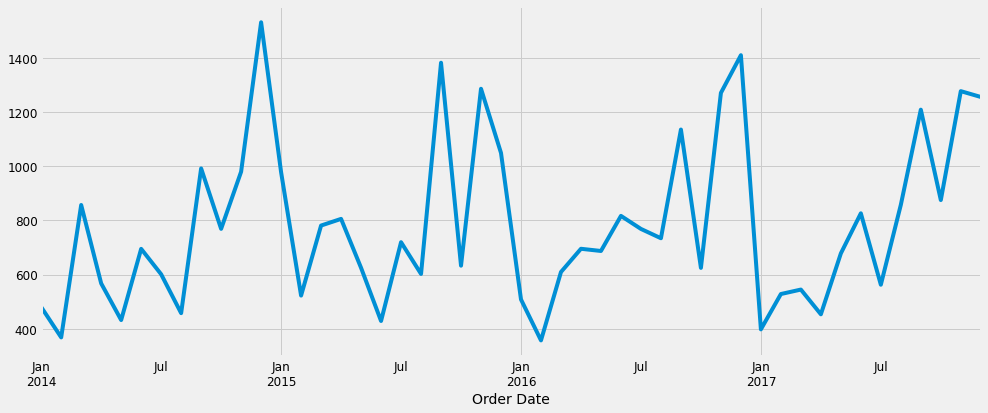

In [14]:
y.plot(figsize=(15, 6))
plt.show()


Sales are low at the beginnig of each year and high at the end (upward trend within each year). There is also a seasonality pattern, as the sales is higher at the final month of the year.

## 1 Forcasting with a self_defined function

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results= mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
                continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1264.3046746655227
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899929659
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1111.6965004450049
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280367373
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.925227075812
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2965.7144602691324
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091437
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673027
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.54010438076796
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.1378388170206
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876927759
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576531115
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1033.8343998014668
ARIMA

#### self_defined result: ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661015012935


## 2 Forcasting with Auto ARIMA


In [17]:
import pmdarima as pm
from pmdarima import model_selection

modl = pm.auto_arima(y, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

#print(modl.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=501.192, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=491.854, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=494.311, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=492.729, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=490.624, Time=0.15 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=498.221, Time=0.12 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=492.535, Time=0.30 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit tim

#### auto_arima result: ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=492.535

#### Although self_defined result has the lowest AIC, auto_arima carries out several checks to ensure the model is numerically well-behaved. So, I continue with this stable and reliable result.

## Building SARIMA Model

In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5106      0.241     -2.118      0.034      -0.983      -0.038
ma.S.L12      -0.3632      0.233     -1.558      0.119      -0.820       0.094
sigma2      3.747e+04   1.76e+04      2.128      0.033    2956.281     7.2e+04


## Visualizing the result

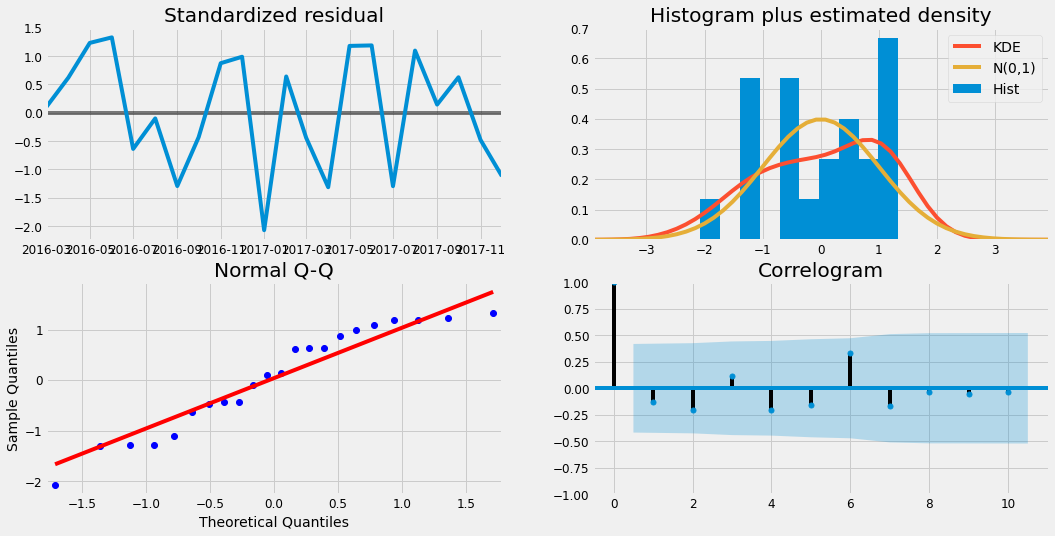

In [19]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()


Risiduals are almost randomly scattered around zero. They are a bit skewed from normal. 

## Compare predicted sales to real sales for 2017

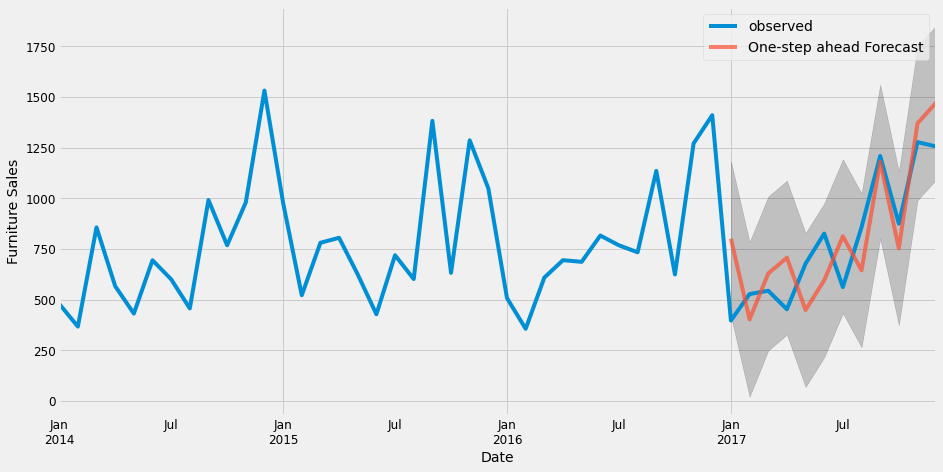

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


It seems that the model captures the trend and seasonality.

## Calculating model's error

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))



The Mean Squared Error of our forecasts is 44595.14
The Root Mean Squared Error of our forecasts is 211.18


## Get forcast for 2 years later

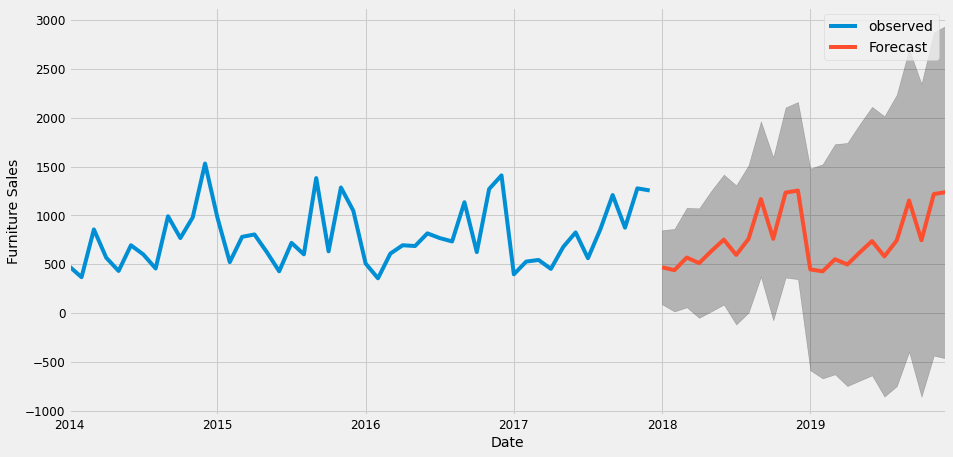

In [23]:
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Discussion

### The conficdence interval (gray area) grow larger as we move further into the future because the forcast is only based on 2014 to 2017 data and it becomes less confident.

### To address above mentioned problem, a learning model must be applied in order to utilize every past point automaticly and apply it in its future calculation.